In [10]:
from os import getcwd, chdir

import numpy as np
import astropy.units as u
import spiceypy as spice

import os

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sunpy.coordinates.frames import HeliocentricEarthEcliptic, HeliographicStonyhurst, Heliocentric
from sunpy.net import Fido, attrs as a
from sunpy.map import Map, make_fitswcs_header
from reproject import reproject_interp

%matplotlib notebook

### Load Spice

In [11]:
cur_dir = os.getcwd()
os.chdir(cur_dir+'/SPICE/kernels/mk')
spice.furnsh('solo_ANC_soc-flown-mk.tm')
# os.chdir(cur_dir)

### Get SDO obs

In [12]:
sdo_query = Fido.search(a.Time('2020-06-07T21:45:00', '2020-06-07T21:47:00'),
                        a.Instrument('AIA'), a.Wavelength(193<<u.angstrom))
sdo_res = Fido.fetch(sdo_query);

### Create map and flare coords

<IPython.core.display.Javascript object>


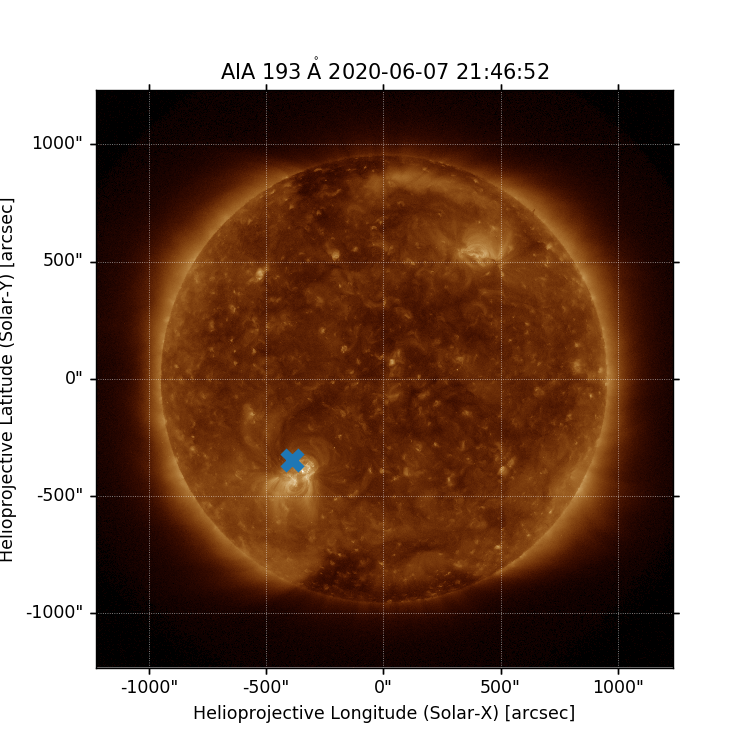

<SkyCoord (HeliocentricEarthEcliptic: obstime=2020-06-07T21:46:52.840): (lon, lat, distance) in (deg, deg, solRad)
    (-28.68378771, -18.15799631, 1.)>

In [40]:


sdo = Map(sdo_res[1]).rotate()

fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(projection=sdo)
sdo.plot(clip_interval=[1,100]*u.percent,  axes=ax )



flare_hpc = SkyCoord(-392*u.arcsec, -348*u.arcsec, frame=sdo.coordinate_frame)
#flare_hpc = SkyCoord(-0*u.arcsec, -0*u.arcsec, frame=sdo.coordinate_frame)
flare_inter = flare_hpc.transform_to(HeliocentricEarthEcliptic)
#print(flare_inter)
flare = SkyCoord(flare_inter.lon, flare_inter.lat, 1*u.Rsun, frame=HeliocentricEarthEcliptic(obstime=sdo.date))
ax.plot_coord(flare, marker='x', markersize=10, markeredgewidth=5)
flare

## Get SDO and SOLO coordinates

In [45]:
sdo_hee = sdo.observer_coordinate.transform_to(HeliocentricEarthEcliptic).represent_as('cartesian')
print(sdo.date.to_datetime())
print(sdo_hee)
solo_hee_spice, _ = spice.spkpos('SOLO', spice.datetime2et(sdo.date.to_datetime()), 'SOLO_HEE_NASA', 'NONE', 'SUN')

solo_hee = HeliocentricEarthEcliptic(solo_hee_spice<<u.km, obstime=sdo.date, representation_type='cartesian')
sdo_hee, solo_hee

2020-06-07 21:46:52.840000
(1.51814348e+11, -28766100.35903549, -14059820.29471375) m


(<CartesianRepresentation (x, y, z) in m
     (1.51814348e+11, -28766100.35903549, -14059820.29471375)>,
 <HeliocentricEarthEcliptic Coordinate (obstime=2020-06-07T21:46:52.840): (x, y, z) in km
     (53849914.37089225, 57222297.09753276, 700301.68447198)>)

<IPython.core.display.Javascript object>


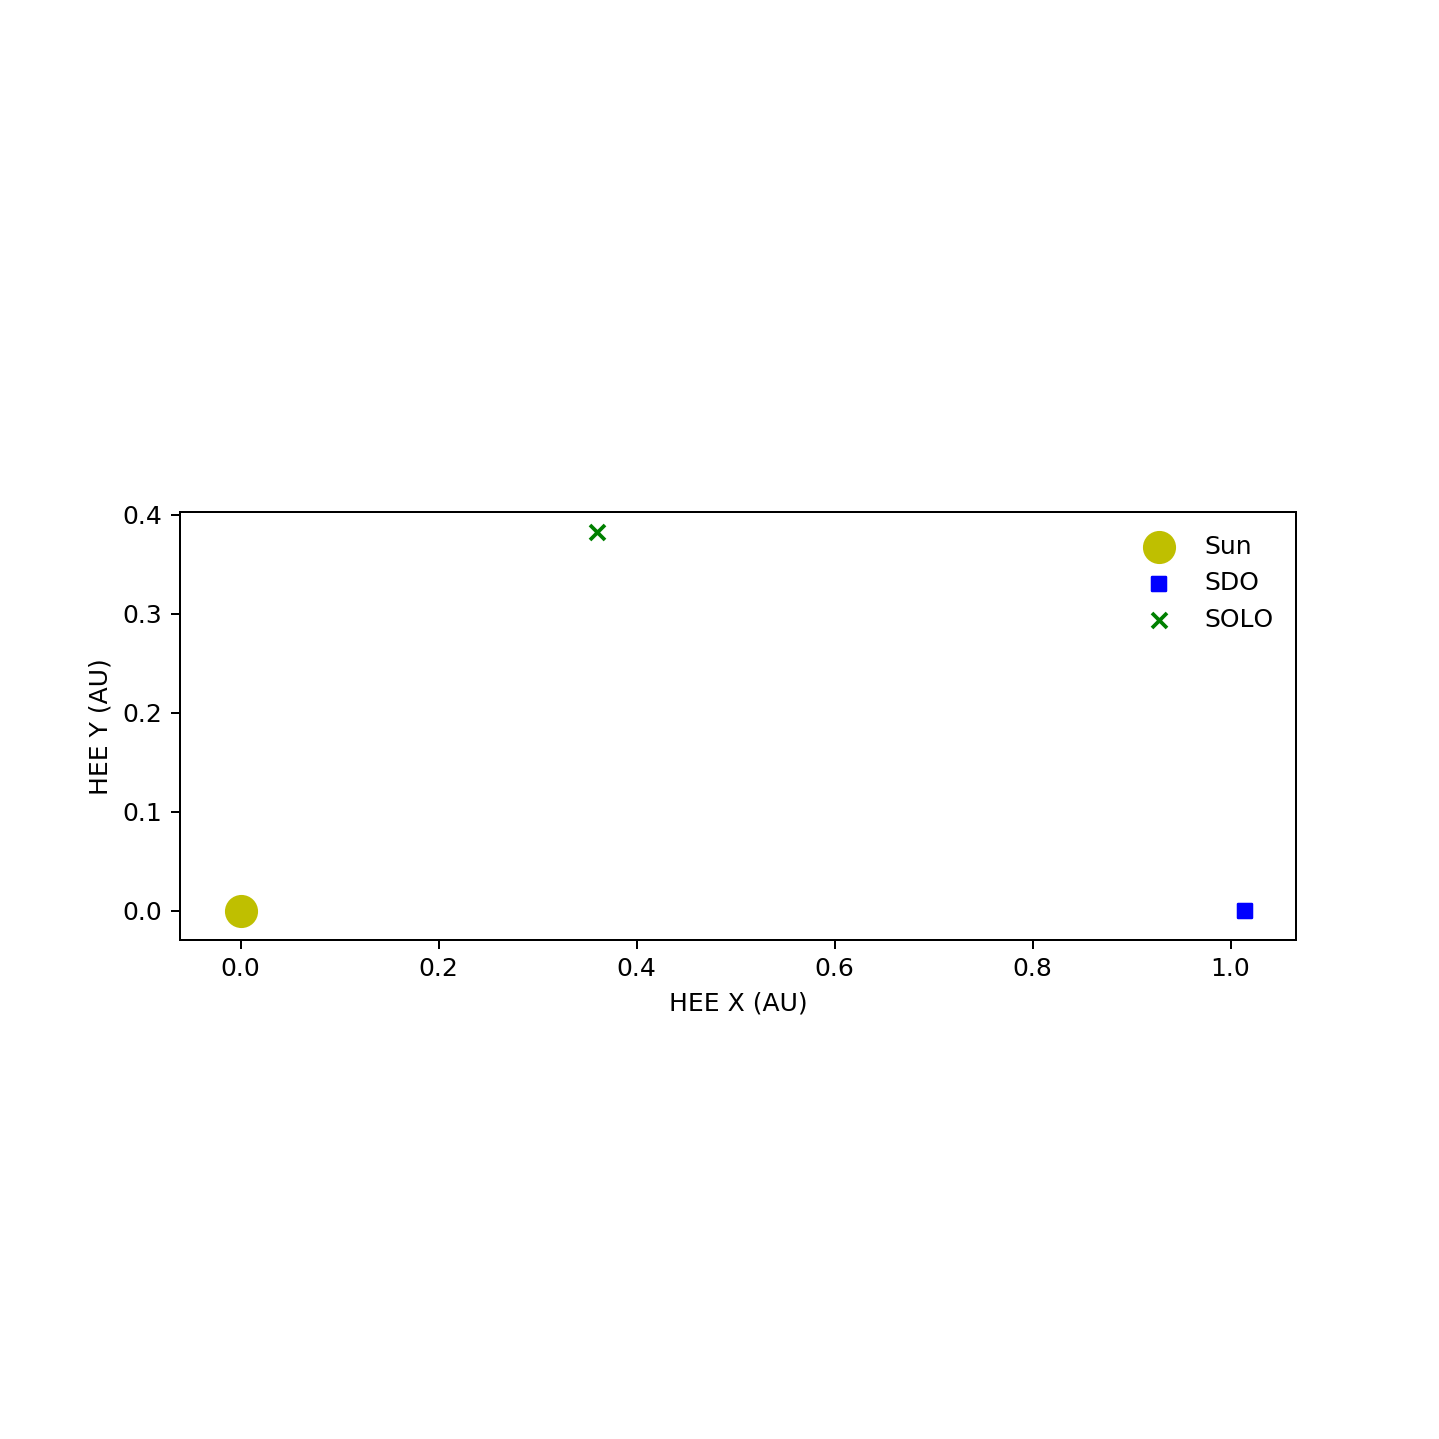

nan deg
-0.010800643607325298 deg


/Users/shane/.virtualenvs/stix/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [34]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
ax.scatter(0, 0, c='y', s=150, label='Sun')
# ax.scatter(stereo_a_hee.x.to('au'), stereo_a_hee.y.to('au'), c='r', marker='d', label='STEREO A')
ax.scatter(sdo_hee.x.to('au'), sdo_hee.y.to('au'), c='b', marker='s', label='SDO')
ax.scatter(solo_hee.x.to('au'), solo_hee.y.to('au'), c='g', marker='x', label='SOLO')
ax.set_xlabel('HEE X (AU)')
ax.set_ylabel('HEE Y (AU)')
ax.set_aspect('equal')
ax.legend(frameon=False)

print(np.rad2deg(np.arcsin(solo_hee.y/solo_hee.x)))
print(np.rad2deg(np.arcsin(sdo_hee.y/sdo_hee.x)))


## Convert using SPICE 

In [35]:
# Vector from 0,0,0 to flare
flare_hee = flare.transform_to(HeliocentricEarthEcliptic)
flare_hee_cart = flare_hee.represent_as('cartesian')
flare_spice = spice.latrec(flare_hee.distance.to('km').value, flare_hee.lon.to(u.radian).value,
                           flare_hee.lat.to(u.radian).value)
print(f'Astropy: {flare_hee_cart.xyz.value}\nSPICE:   {flare_spice}')

# Vector from SOLO to 0,0,0
et = spice.datetime2et(sdo.date.to_datetime())
[state, ltime] = spice.spkezr( 'SUN', et, 'SOLO_HEE_NASA', 'NONE', 'SOLO')

#Vector from SOLO to flare
vec = flare_spice + state[:3]
print(f'Vector to flare from SOLO in HEE: {vec}')

# Rotation matrix 
pform = spice.pxform('SOLO_HEE_NASA', 'SOLO_STIX_ILS', et-ltime)

flare_solo_c = spice.mxvg(pform, vec, 3, 3 )
print(f'Vector to flare from SOLO in STIX_ILS: {flare_solo_c}')

dist, lon, lat = spice.reclat(flare_solo_c)
dist = dist << u.km
lon = lon << u.rad
lon -= -180*u.deg
lat = lat << u.rad

in_fov = spice.fovray('SOLO_STIX', flare_solo_c, 'SOLO_STIX_ILS', 'NONE', 'SOLO', et )

print(f'STIX_ILS lon: {lon.to(u.arcsec)}, lat: {lat.to(u.arcsec)}')
print(f'STIX_ILS lon: {lon.to(u.arcmin)}, lat: {lat.to(u.arcmin)}')
print(f'Ray in FOV: {in_fov}')

Astropy: [ 0.83359443 -0.45607179 -0.31163897]
SPICE:   [ 579931.6451956  -317289.14451678 -216807.23159649]
Vector to flare from SOLO in HEE: [-53271846.40114575 -57538258.12417886   -917213.32612726]
Vector to flare from SOLO in STIX_ILS: [-78415018.8851891    -640708.17849602   -237388.92765532]
STIX_ILS lon: 1685.29714530328 arcsec, lat: -624.410959847633 arcsec
STIX_ILS lon: 28.08828575505467 arcmin, lat: -10.406849330793884 arcmin
Ray in FOV: True


## Convert using Astropy

In [8]:
solo_ref_coord = SkyCoord(sdo.reference_coordinate.Tx, sdo.reference_coordinate.Ty,
                           obstime=sdo.date,
                           observer=solo_hee.transform_to(HeliographicStonyhurst(obstime=sdo.date)),
                           frame="helioprojective")

out_shape = (4048, 4048)
out_header = make_fitswcs_header(
    out_shape,
    solo_ref_coord,
    scale=(1.5, 1.5)*u.arcsec/u.pixel,
    instrument="AIA seen by SOLO",
    observatory="SOLO",
    wavelength=193*u.angstrom
)

out_wcs = WCS(out_header)
out_wcs.heliographic_observer = solo_hee.transform_to(HeliographicStonyhurst(obstime=sdo.date))

In [9]:
output, footprint = reproject_interp(sdo, out_wcs, out_shape)

/Users/shane/.virtualenvs/stix/lib/python3.7/site-packages/reproject/wcs_utils.py:224: RuntimeWarning: invalid value encountered in greater
  reset |= (np.abs(inputs_check[ipix] - inputs[ipix]) > 1)
/Users/shane/.virtualenvs/stix/lib/python3.7/site-packages/reproject/array_utils.py:30: RuntimeWarning: invalid value encountered in less
  reset |= (coords[i] < -0.5)
/Users/shane/.virtualenvs/stix/lib/python3.7/site-packages/reproject/array_utils.py:31: RuntimeWarning: invalid value encountered in greater
  reset |= (coords[i] > original_shape[i] - 0.5)


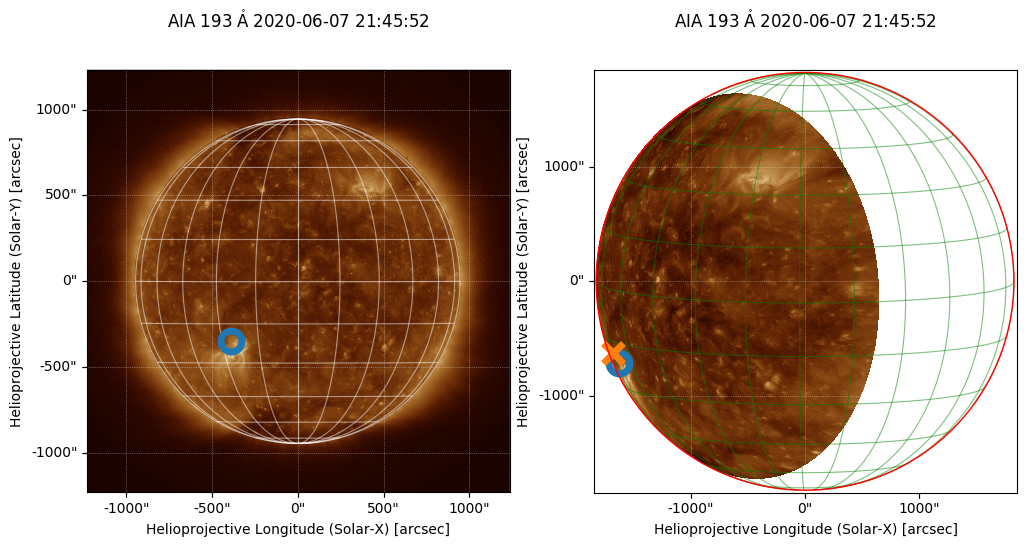

In [24]:
outmap = Map((output, out_header))
outmap = outmap.submap(SkyCoord(sdo.bottom_left_coord.Tx*1.5, sdo.bottom_left_coord.Ty*1.5, frame='helioprojective'),
                       SkyCoord(sdo.top_right_coord.Tx*1.5, sdo.top_right_coord.Ty*1.5, frame='helioprojective'))
outmap.plot_settings = sdo.plot_settings

fig = plt.figure(figsize=(12, 6), dpi=100)

ax1 = fig.add_subplot(1, 2, 1, projection=sdo)
ax1.plot_coord(flare, marker='o', markersize=15, markeredgewidth=5, markerfacecolor='none')
s = sdo.plot(axes=ax1)
sdo.draw_grid(color='w')

ax2 = fig.add_subplot(1, 2, 2, projection=outmap)
ax2.set_title(f'{sdo.wavelength}')
ax2.plot_coord(flare, marker='o', markersize=15, markeredgewidth=5, markerfacecolor='none')
ax2.plot_coord(SkyCoord(-28*u.arcmin, -10.4*u.arcmin, frame=outmap.coordinate_frame), marker='x', markersize=15, markeredgewidth=5)
outmap.plot(axes=ax2)
outmap.draw_grid(color='g')
outmap.draw_limb(color='r')
plt.show()

In [11]:
flare_solo_astropy = flare.transform_to(outmap.coordinate_frame)
flare_solo_astropy

<SkyCoord (Helioprojective: obstime=2020-06-07T21:45:52.840, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2020-06-07T21:45:52.840): (lon, lat, radius) in (deg, deg, m)
    (46.47821416, 5.91719198, 7.85794866e+10)>): (Tx, Ty, distance) in (arcsec, arcsec, solRad)
    (-1628.35161113, -714.17602975, 112.71804947)>

In [12]:
flare_solo_astropy.Tx, flare_solo_astropy.Ty,  flare_solo_astropy.Tx.to('arcmin'), flare_solo_astropy.Ty.to('arcmin')


(<Longitude -1628.35161113 arcsec>,
 <Latitude -714.17602975 arcsec>,
 <Longitude -27.13919352 arcmin>,
 <Latitude -11.90293383 arcmin>)

In [13]:
outmap.rsun_meters

<Quantity 6.957e+08 m>

In [14]:
xyz = flare_solo_astropy.transform_to(HeliocentricEarthEcliptic).represent_as('cartesian')

In [15]:
np.sqrt(np.sum(xyz.xyz**2))

<Quantity 1. solRad>

In [16]:
ac = SkyCoord(x=vec[0]*u.km, y=vec[1]*u.km, z=vec[2]*u.km,
              obstime=sdo.date, frame=HeliocentricEarthEcliptic, representation_type='cartesian')

In [17]:
o = ac.transform_to(outmap.coordinate_frame)

In [18]:
o.Tx.to(u.arcmin), o.Ty.to(u.arcmin)

(<Longitude -13.55559383 arcmin>, <Latitude -5.94538957 arcmin>)

In [19]:
o

<SkyCoord (Helioprojective: obstime=2020-06-07T21:45:52.840, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2020-06-07T21:45:52.840): (lon, lat, radius) in (deg, deg, m)
    (46.47821416, 5.91719198, 7.85794866e+10)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-813.33563006, -356.72337445, 1.56995975e+08)>

In [20]:
flare_solo_c

array([-78414970.79928078,   -640599.89525945,   -237487.11410496])

In [21]:
(60*u.deg).to(u.arcmin)

<Quantity 3600. arcmin>

In [17]:
sdo_res

['/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_45_28_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_46_52_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_46_28_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_45_40_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_45_04_83z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_46_40_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_45_52_84z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_46_04_85z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_45_16_85z_image_lev1.fits', '/home/xiaohl/sunpy/data/aia_lev1_193a_2020_06_07t21_46_16_85z_image_lev1.fits']